# Exercise 11

## Car Price Prediction

Predict if the price of a car is low or high

In [63]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

from pprint import pprint

import warnings
warnings.filterwarnings('ignore')

In [8]:
#data = pd.read_csv('https://github.com/albahnsen/PracticalMachineLearningClass/raw/master/datasets/dataTrain_carListings.zip')
data = pd.read_csv('dataTrain_carListings2.csv')
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data['HighPrice'] = (data['Price'] > data['Price'].mean()).astype(int)
data = data.drop(['Model', 'Price'], axis=1)

data.head()

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE,HighPrice
15,2016,29242,0,0,0,0,1,0,0,1
47,2015,26465,0,0,0,0,1,0,0,1
85,2012,46739,0,1,0,0,0,0,0,1
141,2017,41722,0,0,0,0,0,1,0,1
226,2014,77669,0,0,0,0,0,0,1,0


In [9]:
feature_cols = data.drop(['HighPrice'], axis=1)
feature_cols = feature_cols.columns
feature_cols

Index(['Year', 'Mileage', 'M_Camry', 'M_Camry4dr', 'M_CamryBase', 'M_CamryL',
       'M_CamryLE', 'M_CamrySE', 'M_CamryXLE'],
      dtype='object')

In [10]:
X = data.drop(['HighPrice'], axis=1)
y = data['HighPrice']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Exercise 11.1

Estimate a Decision Tree Classifier Manually using the code created in the Notebook #13

Evaluate the accuracy on the testing set

In [12]:
max_depth = None
num_pct = 10
max_features = None
min_gain=0.001

For feature 1 calculate posible splitting points

In [13]:
j = 1
print(X.columns[j])

Mileage


In [14]:
# Split the variable in num_ctp points
splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / num_pct).tolist())

In [15]:
# Only unique values for filter binary and few unique values features
splits = np.unique(splits)

In [16]:
splits

array([5.00000e+00, 1.58728e+04, 2.32508e+04, 2.98747e+04, 3.56432e+04,
       4.16580e+04, 4.83404e+04, 6.16152e+04, 8.07292e+04, 1.06371e+05])

split the data using split 5

In [17]:
k = 5

In [18]:
filter_l = X.iloc[:, j] < splits[k]

y_l = y.loc[filter_l]
y_r = y.loc[~filter_l]

#### Gini

In [19]:
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)

In [20]:
def gini_impurity(X_col, y, split):
    "Calculate the gain of an split k on feature j"
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

In [21]:
gini_impurity(X.iloc[:, j], y, splits[k])

0.18496148274516044

#### test all splits on all features

In [22]:
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # For all features
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # For all splits
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

In [23]:
j, split, gain = best_split(X_train, y_train, 5)
j, split, gain

(1, 56598.66666666667, 0.23507164147905313)

In [24]:
filter_l = X.iloc[:, j] < split

y_l = y.loc[filter_l]
y_r = y.loc[~filter_l]

### Recursively grow the tree 

In [25]:
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10, max_features = 9):
    
    # If only one observation
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calculate the best split
    j, split, gain = best_split(X, y, num_pct)
    
    # save tree and estimate prediction
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Laplace correction
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    
    # Check stooping criteria
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # No stooping criteria was meet, then continue to create the partition
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Next iteration to each split
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

In [26]:
tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=1, num_pct=10)

{'gain': 0.23872134898880762,
 'level': 0,
 'n_samples': 8810,
 'sl': {'gain': 0.03317687167496233,
  'level': 1,
  'n_samples': 5606,
  'split': -1,
  'y_pred': 1,
  'y_prob': 0.8391583452211127},
 'split': [1, 52187.63636363637],
 'sr': {'gain': 0.04366470703709979,
  'level': 1,
  'n_samples': 3204,
  'split': -1,
  'y_pred': 0,
  'y_prob': 0.12133499688084841},
 'y_pred': 1,
 'y_prob': 0.5780753517930095}

In [27]:
tree = tree_grow(X, y, level=0, min_gain=0.001, max_depth=3, num_pct=10)

In [28]:
tree

{'gain': 0.23348567756020572,
 'level': 0,
 'n_samples': 13150,
 'sl': {'gain': 0.0359166442135464,
  'level': 1,
  'n_samples': 8368,
  'sl': {'gain': 0.06001982703810749,
   'level': 2,
   'n_samples': 565,
   'sl': {'gain': 0.005661757290357922,
    'level': 3,
    'n_samples': 151,
    'split': -1,
    'y_pred': 0,
    'y_prob': 0.058823529411764705},
   'split': [0, 2012.0],
   'sr': {'gain': 0.030742158715547196,
    'level': 3,
    'n_samples': 414,
    'split': -1,
    'y_pred': 0,
    'y_prob': 0.44471153846153844},
   'y_pred': 0,
   'y_prob': 0.3403880070546737},
  'split': [0, 2014.0],
  'sr': {'gain': 0.015250286354762527,
   'level': 2,
   'n_samples': 7803,
   'sl': {'gain': 0.026428677839232695,
    'level': 3,
    'n_samples': 2135,
    'split': -1,
    'y_pred': 1,
    'y_prob': 0.731399157697707},
   'split': [0, 2015.0],
   'sr': {'gain': 0.00819701541689713,
    'level': 3,
    'n_samples': 5668,
    'split': -1,
    'y_pred': 1,
    'y_prob': 0.927336860670194},
 

### Prediction

In [29]:
def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Check if final node
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # If left node is empty only continue with right
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  # If right node is empty only continue with left
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted 

In [30]:
y_pred = tree_predict(X_test, tree)

In [31]:
print('Accuracy:',metrics.accuracy_score(y_pred, y_test))

Accuracy: 0.8619815668202765


# Exercise 11.2

Estimate a Bagging of 10 Decision Tree Classifiers Manually using the code created in the Notebook #13

Evaluate the accuracy on the testing set

In [32]:
np.random.seed(123)
n_samples = X_train.shape[0]

n_estimators = 10
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(n_estimators)]

In [33]:
trees = {}
for i in range(10):
    trees[i] =tree_grow(X_train.iloc[samples[i]], y_train.iloc[samples[i]], max_depth=3)

In [34]:
y_pred_df = pd.DataFrame(index=X_test.index, columns=list(range(n_estimators)))

for i in range(n_estimators):
    y_pred_df.iloc[:, i] = tree_predict(X_test, trees[i])

In [35]:
y_pred = (y_pred_df.sum(axis=1) >= (n_estimators/ 2)).astype(np.int)

In [36]:
print('Accuracy:',metrics.accuracy_score(y_pred, y_test))

Accuracy: 0.8670506912442396


- Al realizar el Bagging de los 10 arboles, la presición aumentó ligeramente en 0.0051

# Exercise 11.3

Implement the variable max_features on the Decision Tree Classifier created in 11.1.

Compare the impact in the results by varing the parameter max_features

Evaluate the accuracy on the testing set

In [39]:
def tree_grow_features(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10,max_features=9):
    
    # If only one observation
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0, random_index=-1)
        return tree
    
    # Calculate the best split  
    sample_index = np.random.choice(a=X.shape[1], size=max_features, replace=False)
    X_sample=X.iloc[:, sample_index]
    j, split, gain = best_split(X_sample, y, num_pct)
    j=sample_index[j]
    # save tree and estimate prediction
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Laplace correction
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level,  random_index=sample_index,split=-1, n_samples=X.shape[0], gain=-1)
    
    # Check stooping criteria
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # No stooping criteria was meet, then continue to create the partition
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]
    tree['gain'] = gain
    tree['random_index']=sample_index
    # Next iteration to each split
    
    tree['sl'] = tree_grow_features(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct,max_features=max_features)
    tree['sr'] = tree_grow_features(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct,max_features=max_features)
    
    return tree

In [40]:
tree= tree_grow_features(X_train, y_train, level=0, min_gain=0.001, max_depth=None, num_pct=10, max_features=9)
y_pred=tree_predict(X_test, tree)
print('Accuracy:',metrics.accuracy_score(y_pred, y_test))

Accuracy: 0.8426267281105991


In [41]:
feature_range = range(1, X_train.shape[1]+1)
# list to store the average Accuracy for each value of max_features
accuracy_scores = []

for n_feature in feature_range:
    tree= tree_grow_features (X_train, y_train, level=0, min_gain=0.001, max_depth=None, num_pct=10, max_features=n_feature)
    y_pred=tree_predict(X_test, tree)
    accuracy_scores.append(metrics.accuracy_score(y_pred, y_test))

Text(0,0.5,'Accuracy')

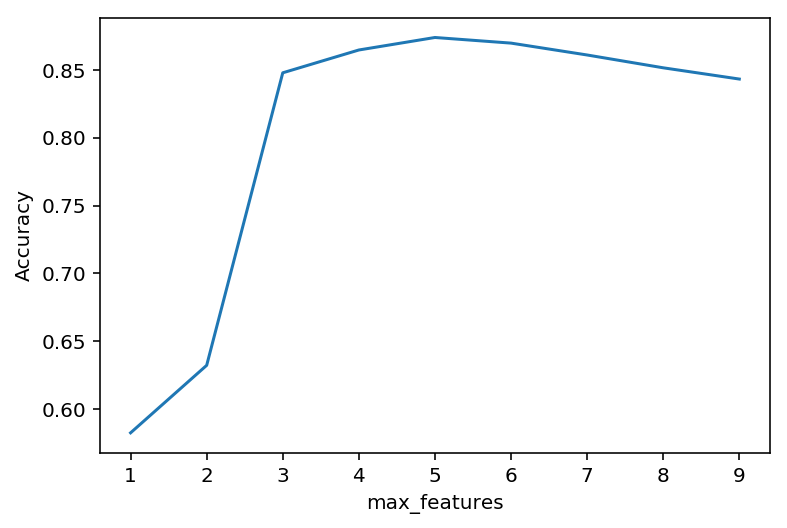

In [42]:
plt.plot(feature_range, accuracy_scores)
plt.xlabel('max_features')
plt.ylabel('Accuracy')

In [43]:
feature_range = range(1, X_train.shape[1]+1)
# list to store the average Accuracy for each value of max_features
accuracy_scores = []

for n_feature in feature_range:   
    accuracy_score_feature = []
    for i in range(5):      
        tree= tree_grow_features(X_train, y_train, level=0, min_gain=0.001, max_depth=None, num_pct=10, max_features=n_feature)
        y_pred=tree_predict(X_test, tree)
        accuracy_score_feature.append(metrics.accuracy_score(y_pred, y_test))
        
    accuracy_scores.append(np.mean(accuracy_score_feature))

Text(0,0.5,'Accuracy')

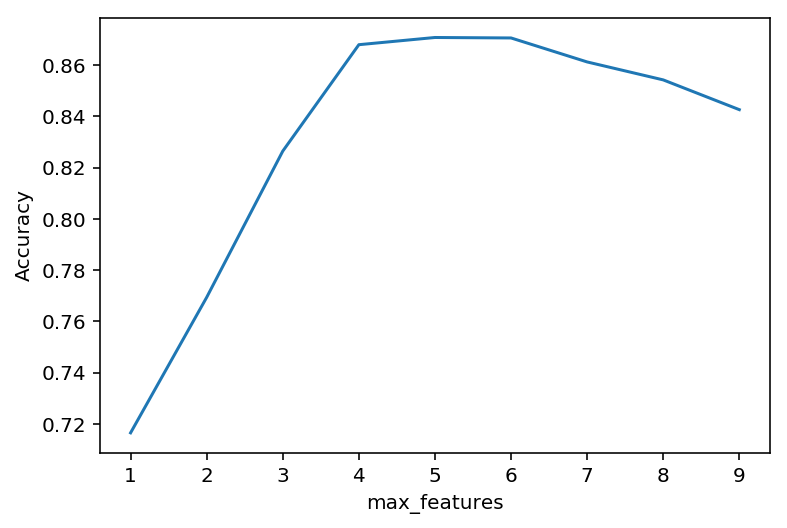

In [44]:
plt.plot(feature_range, accuracy_scores)
plt.xlabel('max_features')
plt.ylabel('Accuracy')

In [45]:
print('Accuracy:',metrics.accuracy_score(y_pred, y_test))

Accuracy: 0.8426267281105991


# Exercise 11.4

Estimate a Bagging of 10 Decision Tree Classifiers with `max_features = log(n_features)`

Evaluate the accuracy on the testing set

In [49]:
trees = {}

for i in range(10):
    trees[i] = tree_grow_features(X_train.iloc[samples[i]], y_train.iloc[samples[i]], level=0, min_gain=0.001, max_depth=None, num_pct=10, max_features=int(np.log(X.shape[1])))
    y_pred_df.iloc[:, i] = tree_predict(X_test, trees[i])

In [50]:
y_pred = (y_pred_df.sum(axis=1) >= (n_estimators/ 2)).astype(np.int)

In [51]:
print('Accuracy:',metrics.accuracy_score(y_pred, y_test))

Accuracy: 0.8714285714285714


- La precisión del modelo aumento en 0.0044 con el parametro max_features = log(n_features)

# Exercise 11.5

Using sklearn, train a RandomForestClassifier

Evaluate the accuracy on the testing set

In [64]:
clf = RandomForestClassifier().fit(X_train, y_train)

In [65]:
#clf = RandomForestClassifier(n_estimators=200, max_features=6, random_state=1, n_jobs=-1).fit(X_train, y_train)

In [66]:
y_pred = clf.predict(X_test)

In [67]:
print('Accuracy:',metrics.accuracy_score(y_pred, y_test))

Accuracy: 0.8387096774193549


# Exercise 11.6

Find the best parameters of the RandomForestClassifier (max_depth, max_features, n_estimators)

Evaluate the accuracy on the testing set

In [56]:
# list of values to try for n_estimators
estimator_range = range(10, 50, 2)

# list to store the average Accuracy for each value of n_estimators
accuracy_scores = []

# use 5-fold cross-validation with each value of n_estimators
for estimator in estimator_range:
    clf = RandomForestClassifier(n_estimators=estimator, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean())

Text(0,0.5,'Accuracy')

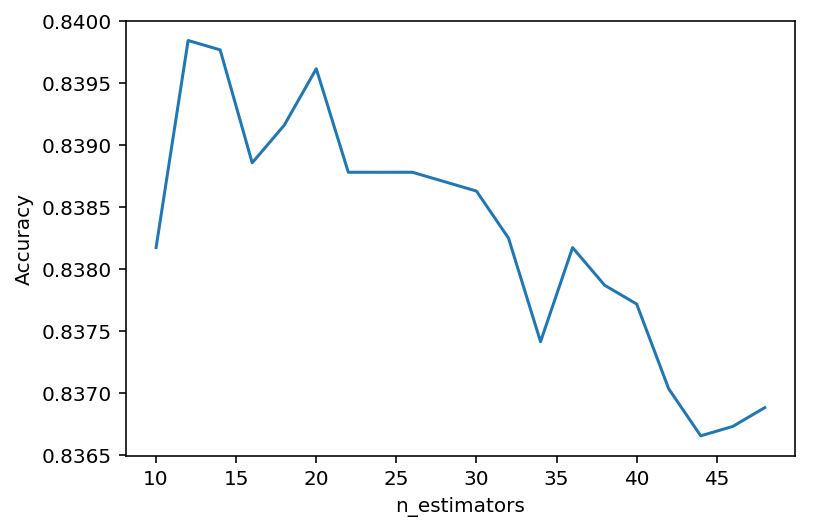

In [57]:
plt.plot(estimator_range, accuracy_scores)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')

- Según la gráfica el número de estimadores que maximiza la precisión es: 12

In [58]:
# list of values to try for max_features
feature_range = range(1, len(feature_cols)+1)

# list to store the average Accuracy for each value of max_features
accuracy_scores = []

# use 10-fold cross-validation with each value of max_features (WARNING: SLOW!)
for feature in feature_range:
    clf = RandomForestClassifier(n_estimators=200, max_features=feature, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean())

Text(0,0.5,'Accuracy')

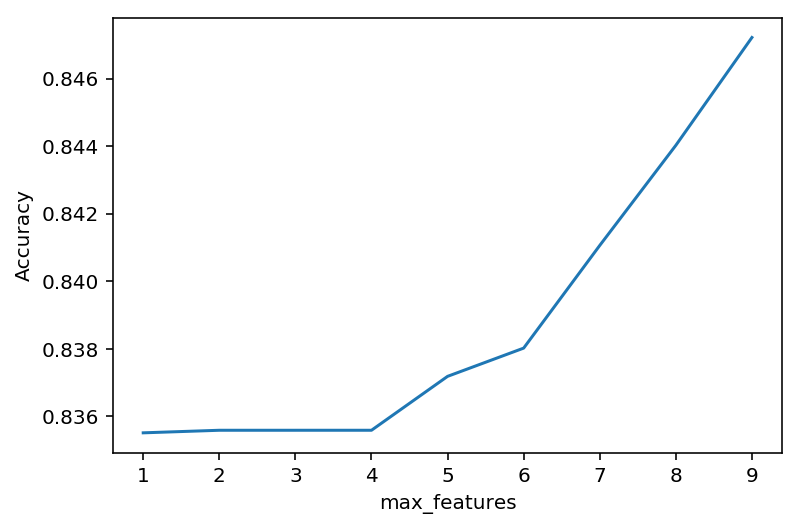

In [59]:
plt.plot(feature_range, accuracy_scores)
plt.xlabel('max_features')
plt.ylabel('Accuracy')

- Según la gráfica el número de features que maximiza la precisión es:9

In [68]:
# list of values to try for max_depth
max_depth_range = range(1, 21)

# list to store the average RMSE for each value of max_depth
accuracy_scores = []


for depth in max_depth_range:
    clf = RandomForestClassifier(max_depth=depth, random_state=1)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=10, scoring='accuracy').mean())

Text(0,0.5,'Accuracy')

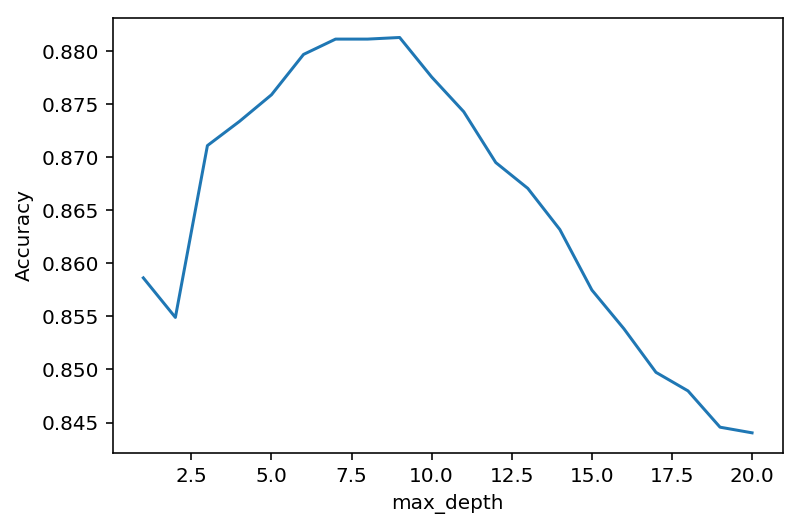

In [61]:
# plot max_depth (x-axis) versus RMSE (y-axis)
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

- Según la gráfica la profundidad que maximiza la precisión es:8.5

In [79]:
# max_features=6 is best and n_estimators=25 is sufficiently large
clf = RandomForestClassifier(n_estimators=12, max_features=9, max_depth=8.5, random_state=1, n_jobs=-1).fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [78]:
print('Accuracy:',metrics.accuracy_score(y_pred, y_test))

Accuracy: 0.8783410138248848


- Con la optimización de los parametros la precisión del modelo usando RandomForestClassifier en 0.0334 con respecto a tomar los parametros por default

### Encontrando los parametros que maximizan la precisión

- Se crea el grid de parametros para buscar la mejor combinación que garantice una mejor precisión.

In [62]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


- Se realizan las combinaciones posibles para estimar los mejores parametros

In [63]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 18.5min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

- Se encuentran los mejores parametros

In [64]:
rf_random.best_params_

{'n_estimators': 400,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': True}

In [74]:
regr = RandomForestClassifier(max_depth=10, random_state=42, n_jobs = -1, n_estimators=400, min_samples_split=2, min_samples_leaf=4, max_features='sqrt', bootstrap=True).fit(X_train, y_train)
y_pred = regr.predict(X_test)

In [75]:
print('Accuracy:',metrics.accuracy_score(y_pred, y_test))

Accuracy: 0.8799539170506913


- Comparando la precisíon del modelo estimando los parametros de forma gráfica vs el modelo que usa el grid se observa una mejora de: 0.0016